# Anomaly Detection with GANs for Multivariate Time Series
https://arxiv.org/pdf/1809.04758.pdf

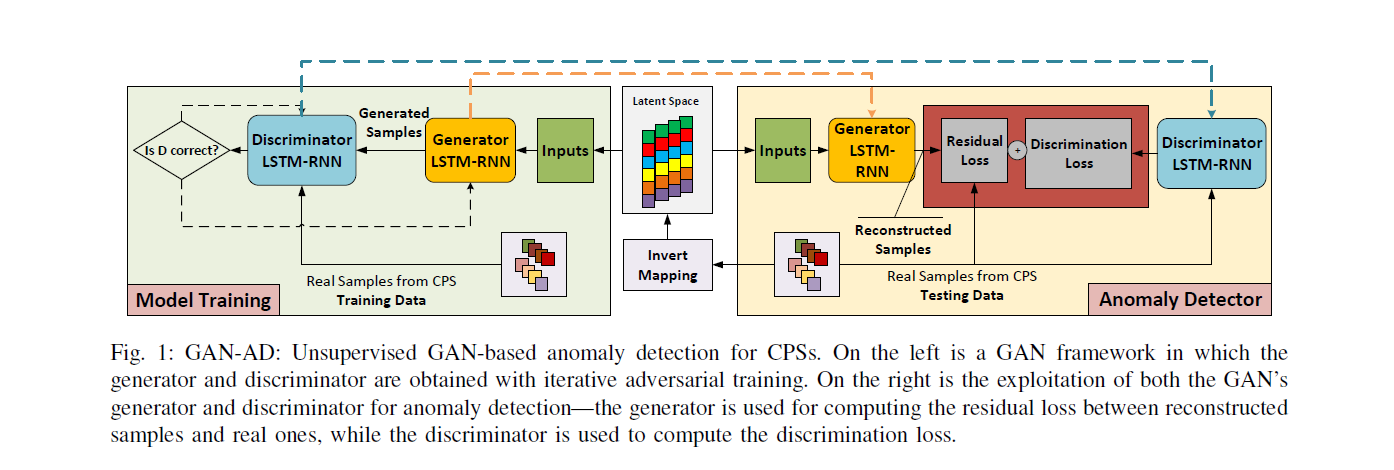

In [9]:
import os
import json
import pandas as pd
import numpy as np
from tensorflow import keras
import random
from datetime import date
import matplotlib.pyplot as plt
from IPython.display import display, Markdown
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from time_series_anomaly_detection.detector import GAN_AD

# Numenta Anomaly Benchmark (NAB)

Lavin, Alexander and Ahmad, Subutai. "Evaluating Real-time Anomaly Detection Algorithms – the Numenta Anomaly Benchmark", Fourteenth International Conference on Machine Learning and Applications, December 2015.

https://www.kaggle.com/boltzmannbrain/nab <br>
https://github.com/numenta/NAB

## Data preparation

In [14]:
# single univariate time series
dataset_name = "realAWSCloudwatch/ec2_cpu_utilization_53ea38.csv"
df_original = pd.read_csv("../datasets/NAB/realAWSCloudwatch/" + dataset_name, index_col='timestamp', sep=',').reset_index()

Original data - example visualisation

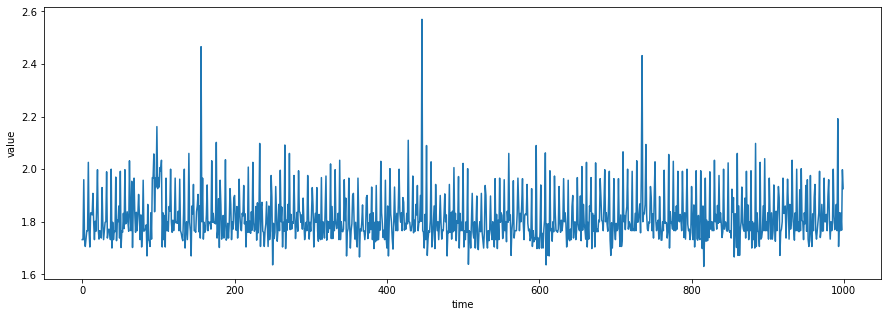

In [15]:
display(Markdown('Original data - example visualisation'))
plt.figure(figsize=(15,5))
plt.xlabel('time')
plt.ylabel('value')
plt.plot(df_original['value'][:1000])
plt.show()

In [17]:
with open("../datasets/NAB/combined_labels.json", "r") as read_file:
    df_anomalies = json.load(read_file)

In [23]:
anomalies_timestamps = df_anomalies[dataset_name]
anomalies_index = np.array(df_original[df_original['timestamp'].apply(lambda x : x in anomalies_timestamps)].index)
anomalies_index

array([1496, 2659], dtype=int64)

In [27]:
df_original.shape

(4032, 2)

In [100]:
# create test (multiple univariate time series) dataset from the anomalies and neighbouring data points
padding = 5
df_test = list([df_original.iloc[index-padding:index+padding,:].copy() for index in anomalies_index])

for df, i in zip(df_test, range(0, len(df_test))):
      df['id'] = i  
        
df_test = pd.concat([df for df in df_test], ignore_index=True)

In [101]:
df_test

,timestamp,value,id
0,2014-02-19 18:45:00,1.766,0
1,2014-02-19 18:50:00,1.892,0
2,2014-02-19 18:55:00,1.604,0
3,2014-02-19 19:00:00,1.860,0
4,2014-02-19 19:05:00,1.706,0
5,2014-02-19 19:10:00,2.058,0
6,2014-02-19 19:15:00,1.800,0
7,2014-02-19 19:20:00,1.872,0
8,2014-02-19 19:25:00,1.924,0
9,2014-02-19 19:30:00,1.972,0


In [98]:
df_test['label'] = df_test['timestamp'].apply(lambda x : 1 if x in anomalies_timestamps else 0)
df_test.pop('timestamp')
df_anomalies_labels = pd.DataFrame(df_test.pop('label'), columns=['label'])

In [94]:
# create train (multiple univariate time series) dataset without the anomalies and neighbouring data points

anomalies_index[0]
anomalies_index[1:-1]
anomalies_index[-1]

5

In [35]:
df_train = df_original.drop(df_test.index)
df_train.shape
# TODO id columns?


(3912, 2)

In [32]:

# df_test.drop(columns=['timestamp'], inplace=True)

,label
1491,0
1492,0
1493,0
1494,0
1495,0
1496,1
1497,0
1498,0
1499,0
1500,0


## Hyperparameter settings

The selected values appeared during the performed experiments as the most promising. 
"Finer" search was not conducted as this is only a toy-example demonstration, and the detector won't be used on this data.
I recommend using coarse to fine technique to find the most optimal set of hyper-parameters if needed.

In [9]:
window_size = 8
shift = 3
batch_size = 16
latent_dim = 1 
epochs = 10000

## Training

In [10]:
gan_ad = GAN_AD(window_size = window_size, shift = shift, batch_size = batch_size, latent_dim = latent_dim)
gan_ad.fit(df_train, epochs, save_checkpoints=True, enable_prints=True)
# gan_ad.save_model("gan_ad_" + str(date.today()) + "-cpu.h5")

KeyboardInterrupt: 

## Evaluation demonstration

### Anomaly free (training) data

In [11]:
# data shorter than one window returns NaN Series
anomaly_scores = gan_ad.predict_anomaly_scores(pd.DataFrame(df_train[0:0+window_size-5]))
anomaly_scores

0   NaN
1   NaN
2   NaN
dtype: float64

Anomaly free (training) data with NaNs - anomaly scores

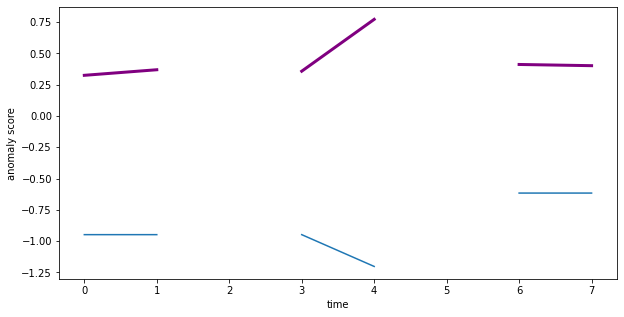

In [12]:
# one window with NaN values
window_with_nan = pd.DataFrame(df_train[0:window_size].copy())
window_with_nan.iloc[[2,5], [0]] = np.nan

display(Markdown('Anomaly free (training) data with NaNs - anomaly scores'))
anomaly_scores = gan_ad.predict_anomaly_scores(window_with_nan)
data = gan_ad.transform_data(window_with_nan)
plt.figure(figsize=(10,5))
plt.xlabel('time')
plt.ylabel('anomaly score')
plt.plot(data)
plt.plot(anomaly_scores, color='purple', lw=3)
plt.show()

Anomaly free (training) data - anomaly scores

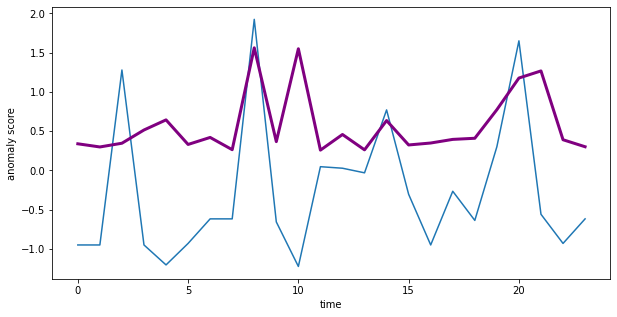

In [13]:
# more than one window
display(Markdown('Anomaly free (training) data - anomaly scores'))
anomaly_scores = gan_ad.predict_anomaly_scores(pd.DataFrame(df_train[0:(2*window_size)+8]))
data = gan_ad.transform_data(pd.DataFrame(df_train[0:(2*window_size)+8]))
plt.figure(figsize=(10,5))
plt.xlabel('time')
plt.ylabel('anomaly score')
plt.plot(data)
plt.plot(anomaly_scores, color='purple', lw=3)
plt.show()

In [14]:
# average anomaly score
anomaly_scores = gan_ad.predict_anomaly_scores(pd.DataFrame(df_train[0:(100*window_size)]))
avg_score = anomaly_scores.sum()/(100*window_size)
display(Markdown('Anomaly free (training) data - Average anomaly score: %.2f' % avg_score))

KeyboardInterrupt: 

### Anomaly free (test) data

Anomaly free (test) data - anomaly scores

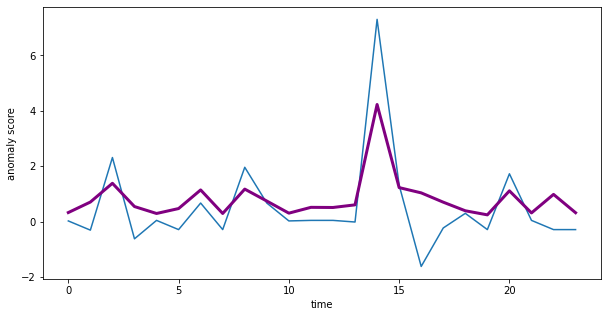

In [15]:
# more than one window
display(Markdown('Anomaly free (test) data - anomaly scores'))
anomaly_scores = gan_ad.predict_anomaly_scores(pd.DataFrame(df_original_test[0:(3*window_size)])) #TODO
data = gan_ad.transform_data(pd.DataFrame(df_original_test[0:(3*window_size)]))
plt.figure(figsize=(10,5))
plt.xlabel('time')
plt.ylabel('anomaly score')
plt.plot(data)
plt.plot(anomaly_scores, color='purple', lw=3)
plt.show()

In [ ]:
# average anomaly score
anomaly_scores = gan_ad.predict_anomaly_scores(pd.DataFrame(df_original_test[0:(100*window_size)]))
avg_score = anomaly_scores.sum()/(100*window_size)
display(Markdown('Anomaly free (test) data - Average anomaly score: %.2f' % avg_score))

### Data with anomalies

Original data with anomalies

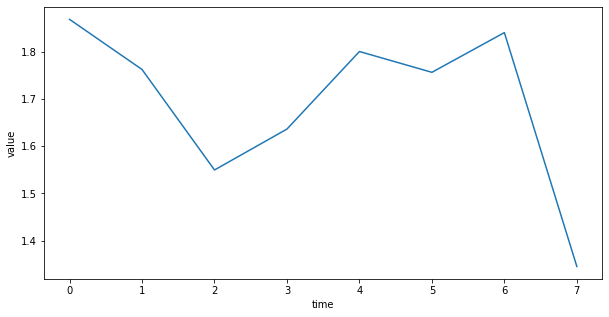

Scaled data with anomalies - true anomalies

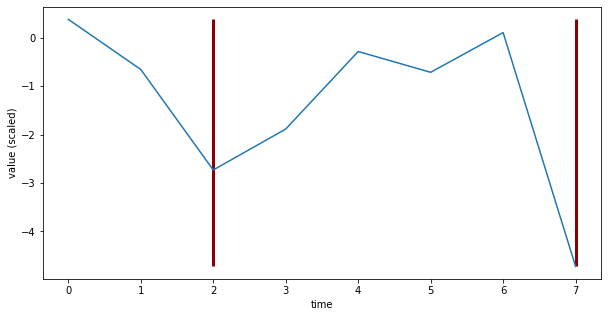

Scaled data with anomalies - predicted anomaly scores

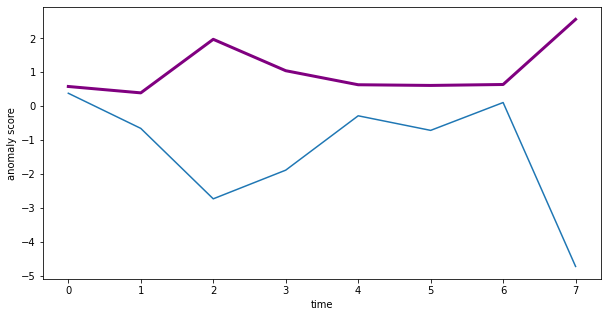

Scaled data with anomalies - predicted anomalies

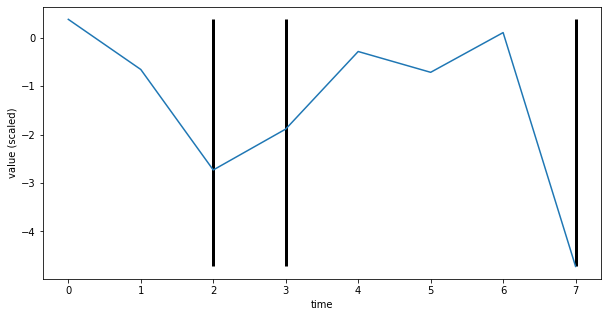

In [20]:
# one window
display(Markdown('Original data with anomalies'))
data = pd.DataFrame(df_with_anomalies[0:window_size])
plt.figure(figsize=(10,5))
plt.xlabel('time')
plt.ylabel('value')
plt.plot(data)
plt.show()

display(Markdown('Scaled data with anomalies - true anomalies'))
data = gan_ad.transform_data(pd.DataFrame(df_with_anomalies[0:window_size]))
plt.figure(figsize=(10,5))
plt.xlabel('time')
plt.ylabel("value (scaled)")
plt.plot(data)
labels = pd.DataFrame(df_anomalies_labels[0:window_size]).replace(0,np.nan).dropna().index
plt.vlines(x=labels, ymin=np.min(np.min(data)), ymax=np.max(np.max(data)), colors='darkred', ls='-', lw=3, label='vline_single - full height')
plt.show()

display(Markdown('Scaled data with anomalies - predicted anomaly scores'))
anomaly_scores = gan_ad.predict_anomaly_scores(pd.DataFrame(df_with_anomalies[0:window_size]))
plt.figure(figsize=(10,5))
plt.xlabel('time')
plt.ylabel('anomaly score')
plt.plot(data)
plt.plot(anomaly_scores, color='purple', lw=3)
plt.show()

display(Markdown('Scaled data with anomalies - predicted anomalies'))
predicted = gan_ad.identify_anomaly(pd.DataFrame(df_with_anomalies[0:window_size]), threshold = 0)
predicted_labels = pd.DataFrame(predicted).replace(0,np.nan).dropna().index
plt.figure(figsize=(10,5))
plt.xlabel('time')
plt.ylabel("value (scaled)")
plt.plot(data)
plt.vlines(x=predicted_labels, ymin=np.min(np.min(data)), ymax=np.max(np.max(data)), colors='black', ls='-', lw=3, label='vline_single - full height')
plt.show()

Original data with anomalies

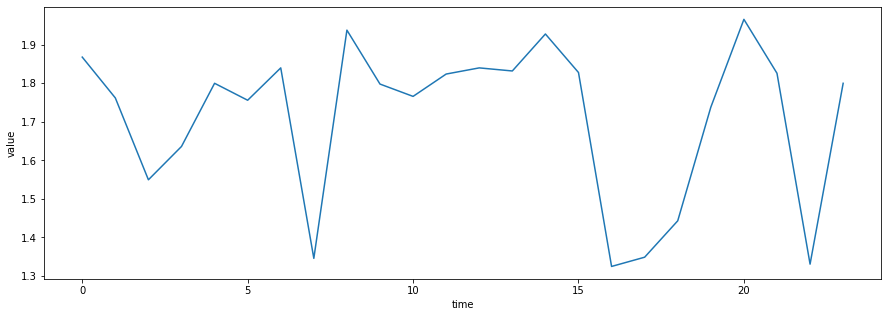

Scaled data with anomalies - true anomalies

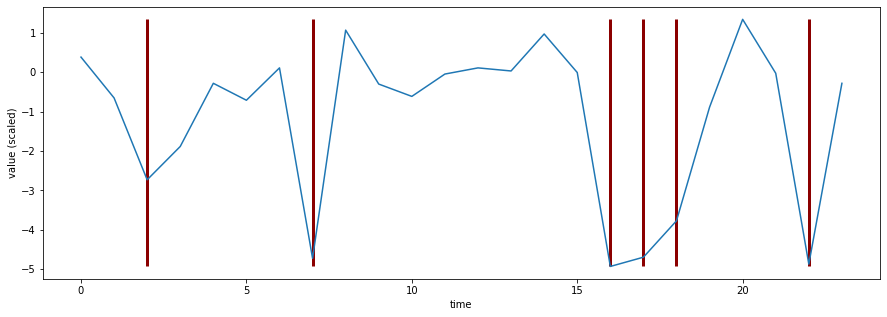

Scaled data with anomalies - predicted anomaly scores

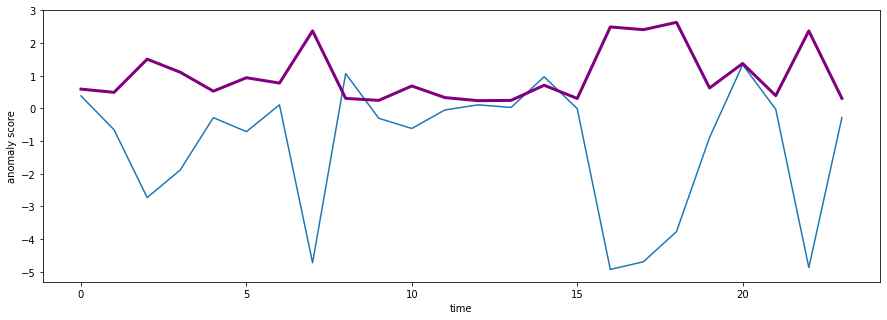

Scaled data with anomalies - predicted anomalies

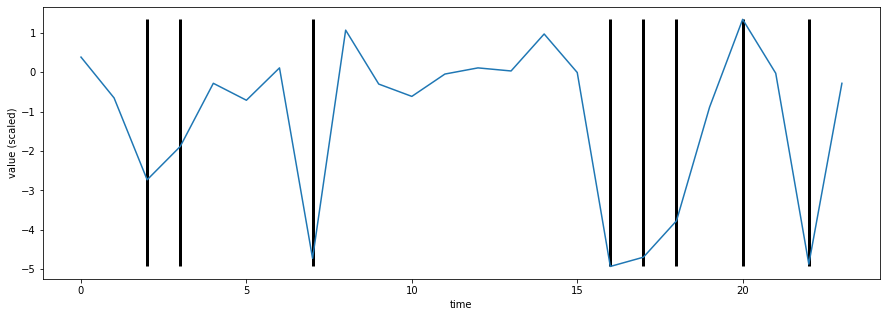

In [19]:
# more than one window
display(Markdown('Original data with anomalies'))
data = pd.DataFrame(df_with_anomalies[0:(3*window_size)])
plt.figure(figsize=(15,5))
plt.xlabel('time')
plt.ylabel('value')
plt.plot(data)
plt.show()

display(Markdown('Scaled data with anomalies - true anomalies'))
data = gan_ad.transform_data(pd.DataFrame(df_with_anomalies[0:(3*window_size)]))
plt.figure(figsize=(15,5))
plt.xlabel('time')
plt.ylabel("value (scaled)")
plt.plot(data)
labels = pd.DataFrame(df_anomalies_labels[0:(3*window_size)]).replace(0,np.nan).dropna().index
plt.vlines(x=labels, ymin=np.min(np.min(data)), ymax=np.max(np.max(data)), colors='darkred', ls='-', lw=3, label='vline_single - full height')
plt.show()

display(Markdown('Scaled data with anomalies - predicted anomaly scores'))
anomaly_scores = gan_ad.predict_anomaly_scores(pd.DataFrame(df_with_anomalies[0:(3*window_size)]))
plt.figure(figsize=(15,5))
plt.xlabel('time')
plt.ylabel('anomaly score')
plt.plot(data)
plt.plot(anomaly_scores, color='purple', lw=3)
plt.show()

display(Markdown('Scaled data with anomalies - predicted anomalies'))
predicted = gan_ad.identify_anomaly(pd.DataFrame(df_with_anomalies[0:(3*window_size)]), threshold = 0)
predicted_labels = pd.DataFrame(predicted).replace(0,np.nan).dropna().index
plt.figure(figsize=(15,5))
plt.xlabel('time')
plt.ylabel("value (scaled)")
plt.plot(data)
plt.vlines(x=predicted_labels, ymin=np.min(np.min(data)), ymax=np.max(np.max(data)), colors='black', ls='-', lw=3, label='vline_single - full height')
plt.show()

In [40]:
# average anomaly score
anomaly_scores = gan_ad.predict_anomaly_scores(pd.DataFrame(df_with_anomalies[0:(100*window_size)]))
avg_score = anomaly_scores.sum()/(100*window_size)
display(Markdown('Data with anomalies - Average anomaly score: %.2f' % avg_score))

Data with anomalies - Average anomaly score: 0.61

In [53]:
y_true = np.array(df_anomalies_labels[0:(100*window_size)])

In [56]:
predicted = gan_ad.identify_anomaly(pd.DataFrame(df_with_anomalies[0:(100*window_size)]), threshold = 0)

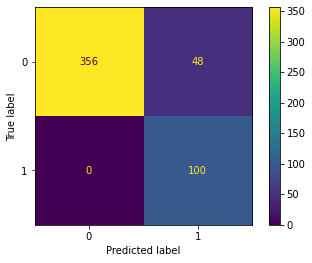

In [54]:
y_pred = np.array(predicted)
disp = ConfusionMatrixDisplay(confusion_matrix(y_true, y_pred))
disp.plot()